<p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:200%;text-align:center;border-radius:15px 15px;">Model Training for Auto 2W Loan Approval</p>

#### 1.1 Import Data and Required Packages
##### Importing Basic, Preprocessing and Model Training Library.

In [1]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

#Preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV

# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import warnings

#### Import the CSV Data as Pandas DataFrame

In [2]:
df = pd.read_csv('data/credit_data.csv')

In [3]:
#dropping duplicate records
df = df.drop_duplicates()

In [4]:
# Treating missing values
df['Occupation'] = df['Occupation'].fillna('Others')

In [5]:
#Feature Engineering and Removing Very low cost vehicle data
df['TwoWheeler Cost'] = round((df['Loan Amount']/df['LTV Ratio'])*100,0)

df = df[df['TwoWheeler Cost']>=20000.0]

#### Preparing X and Y variables

In [6]:
X = df.drop(columns=['Profile Score','TwoWheeler Cost'],axis=1)
y = df['Profile Score']

In [7]:
# Create Column Transformer with 3 types of transformers
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, cat_features),
         ("StandardScaler", numeric_transformer, num_features),        
    ]
)

In [8]:
X = preprocessor.fit_transform(X)

In [9]:
#creating three sets - training, test and validation
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Splitting temporary set into validation and test sets
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.25, random_state=42)

#### Create an Evaluate Function to give all metrics after model Training

In [10]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [ ]:
#Trying out different models for the best performance
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "XGBRegressor": XGBRegressor(verbosity=0),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
}

In [ ]:
# Defining Hyper Parameters for fine tuning and selecting the best model
params = {
    "Linear Regression": {
        'fit_intercept': [True, False]
    },
    "Lasso": {
        'alpha': [0.1, 0.01, 0.001]
    },
    "Ridge": {
        'alpha': [0.1, 0.01, 0.001]
    },
    "Decision Tree": {
        'criterion': ['absolute_error','squared_error', 'friedman_mse', 'poisson'],
        'splitter': ['best', 'random'],
        'max_features': ['sqrt', 'log2'],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 4, 8],
    },
    "Random Forest Regressor": {
        'n_estimators': [16,64, 128],
        'max_features': ['sqrt', 'log2'],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 4],
    },
    "XGBRegressor": {
        'learning_rate': [0.1, 0.01, 0.05],
        'n_estimators': [8, 16, 32, 64,128],
        'max_depth': [3, 4, 6,8],
        'subsample': [0.6, 0.7, 0.8, 0.9],
    }
}

### Running Hyper Parameter tuning for different models

In [11]:
#Defining model_list and r2_list to get the performance benchmark for all models
model_list = []
r2_list =[]

report = {}

#Hyper parameter tuning for each model in the original list across different params
for i in range(len(list(models))):
    model = list(models.values())[i]
    para=params[list(models.keys())[i]]
    
    gs = RandomizedSearchCV(model, param_distributions=para, cv=3, n_iter=50,n_jobs=-1)
  
    gs.fit(X_train,y_train)

    model.set_params(**gs.best_params_)
    model.fit(X_train,y_train)

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_val, y_val_pred)

    test_model_score = r2_score(y_val,y_val_pred)
    
    report[list(models.keys())[i]] = test_model_score
        
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    best_params = gs.best_params_
    best_estimator = gs.best_estimator_
    best_score = gs.best_score_
    
    # Print the best parameters and best score
    print("Best Parameters:", best_params)
    print("Best Score:", best_score)
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')

/Users/kianathakkar/Documents/AutoLoanApproval/venv/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 2 is smaller than n_iter=50. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Linear Regression
Best Parameters: {'fit_intercept': True}
Best Score: 0.7285763218574436
Model performance for Training set
- Root Mean Squared Error: 12.7507
- Mean Absolute Error: 10.4687
- R2 Score: 0.7289
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 12.7309
- Mean Absolute Error: 10.4695
- R2 Score: 0.7284




/Users/kianathakkar/Documents/AutoLoanApproval/venv/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 3 is smaller than n_iter=50. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Lasso
Best Parameters: {'alpha': 0.01}
Best Score: 0.7285970399995287
Model performance for Training set
- Root Mean Squared Error: 12.7546
- Mean Absolute Error: 10.4746
- R2 Score: 0.7287
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 12.7348
- Mean Absolute Error: 10.4759
- R2 Score: 0.7282




/Users/kianathakkar/Documents/AutoLoanApproval/venv/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 3 is smaller than n_iter=50. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Ridge
Best Parameters: {'alpha': 0.1}
Best Score: 0.7285797066145973
Model performance for Training set
- Root Mean Squared Error: 12.7507
- Mean Absolute Error: 10.4687
- R2 Score: 0.7289
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 12.7309
- Mean Absolute Error: 10.4695
- R2 Score: 0.7284




/Users/kianathakkar/Documents/AutoLoanApproval/venv/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/kianathakkar/Documents/AutoLoanApproval/venv/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/kianathakkar/Documents/AutoLoanApproval/venv/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/kianathakkar/Documents/AutoLoanApproval/venv/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  

XGBRegressor
Best Parameters: {'subsample': 0.8, 'n_estimators': 128, 'max_depth': 8, 'learning_rate': 0.1}
Best Score: 0.882661699127513
Model performance for Training set
- Root Mean Squared Error: 7.1776
- Mean Absolute Error: 5.6737
- R2 Score: 0.9141
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 8.2658
- Mean Absolute Error: 6.4489
- R2 Score: 0.8855


Decision Tree
Best Parameters: {'splitter': 'best', 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'criterion': 'friedman_mse'}
Best Score: 0.8207328467129612
Model performance for Training set
- Root Mean Squared Error: 8.5028
- Mean Absolute Error: 6.1663
- R2 Score: 0.8794
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 10.1004
- Mean Absolute Error: 7.3642
- R2 Score: 0.8290




/Users/kianathakkar/Documents/AutoLoanApproval/venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Random Forest Regressor
Best Parameters: {'n_estimators': 64, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Best Score: 0.8924535911750349
Model performance for Training set
- Root Mean Squared Error: 2.8018
- Mean Absolute Error: 2.0555
- R2 Score: 0.9869
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 7.3207
- Mean Absolute Error: 5.4793
- R2 Score: 0.9102




### Results - Random forest is best but overfits the data

In [12]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
5,Random Forest Regressor,0.910187
3,XGBRegressor,0.885499
4,Decision Tree,0.829032
2,Ridge,0.728387
0,Linear Regression,0.728384
1,Lasso,0.728220


### Final Model - XG boost 

In [13]:
#Finalizing XG boost which is best combination of training and cross validation performance
model = XGBRegressor()
xgb = XGBRegressor(subsample=0.6, n_estimators=128, max_depth=8, learning_rate=0.1)

xgb_trained = xgb.fit(X_train, y_train)

y_test_pred = xgb_trained.predict(X_test)

y_val_pred =  xgb_trained.predict(X_val)

model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

model_val_mae , model_val_rmse, model_val_r2 = evaluate_model(y_val, y_val_pred)

print(" RMSE of the model on test set is %.2f" %model_test_rmse)

print(" R2 of the model on test set is %.2f" %model_test_r2)

print(" RMSE of the model on validation set is %.2f" %model_val_rmse)

print(" R2 of the model on validation set is %.2f" %model_val_r2)


/Users/kianathakkar/Documents/AutoLoanApproval/venv/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


 RMSE of the model on test set is 8.27
 R2 of the model on test set is 0.88
 RMSE of the model on validation set is 8.28
 R2 of the model on validation set is 0.89


### Plot y_pred and y_test

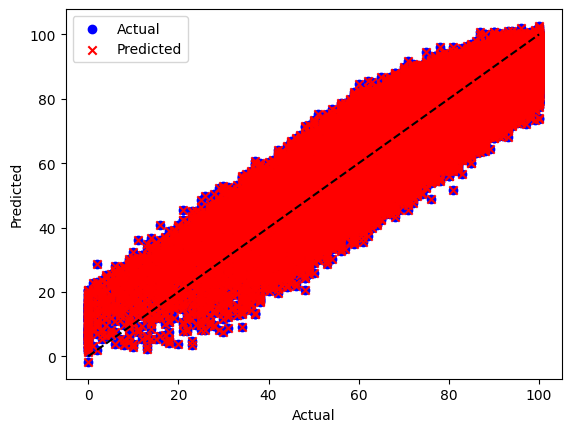

In [24]:
# Scatter plot with different markers or colors for actual and predicted
plt.scatter(y_test, y_test_pred, label='Actual', marker='o', c='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black')

plt.xlabel('Actual')
plt.ylabel('Predicted')

# You can also add a legend to distinguish between actual and predicted
plt.scatter(y_test, y_test_pred, label='Predicted', marker='x', c='red')
plt.legend()

plt.show()

### Plotting histogram of residuals

/Users/kianathakkar/Documents/AutoLoanApproval/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/kianathakkar/Documents/AutoLoanApproval/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


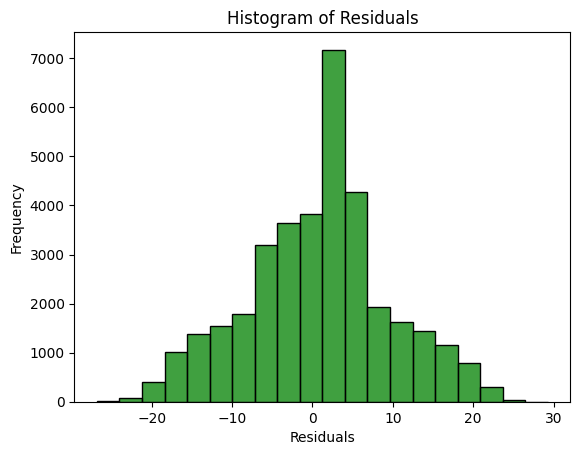

In [35]:
y_test_pred = y_test_pred.flatten()
residuals = y_test - y_test_pred

sns.histplot(residuals, bins=20,color='green')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

#### Difference between Actual and Predicted Values

In [19]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_test_pred,'Difference':y_test-y_test_pred})
pred_df

,Actual Value,Predicted Value,Difference
12365,96,97.083435,-1.083435
79571,77,65.594978,11.405022
67139,96,97.461075,-1.461075
236574,97,96.509193,0.490807
5911,70,80.226273,-10.226273
...,...,...,...
87653,100,94.419853,5.580147
81532,66,51.330139,14.669861
35233,100,96.594246,3.405754
155832,85,93.130638,-8.130638


## Model Training using Tensorflow (Neural Net)

In [40]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import initializers
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

In [21]:
# Convert the CSR matrix to a dense Numpy array
X_dense = X_train.toarray()

# Convert the Pandas Series to a Numpy array
Y_array = y_train.values

# Create a Keras Sequential model
model = Sequential()


# Add your layers here
model.add(Dense(128, activation='relu', input_shape=(X_dense.shape[1],), kernel_initializer=initializers.he_normal()))  # Add a hidden layer with 128 units and ReLU activation
model.add(Dense(64, activation='relu',kernel_initializer=initializers.he_normal()))  # Add another hidden layer with 64 units and ReLU activation
model.add(Dense(1, activation='linear',kernel_initializer=initializers.he_normal()))  # Output layer (linear activation)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
history = model.fit(X_dense, Y_array, epochs=30, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/30
2670/2670 [==============================] - 2s 578us/step - loss: 241.8021 - val_loss: 80.1973
Epoch 2/30
2670/2670 [==============================] - 1s 532us/step - loss: 79.5935 - val_loss: 80.3360
Epoch 3/30
2670/2670 [==============================] - 1s 517us/step - loss: 79.3695 - val_loss: 83.3498
Epoch 4/30
2670/2670 [==============================] - 1s 528us/step - loss: 78.7984 - val_loss: 78.7758
Epoch 5/30
2670/2670 [==============================] - 1s 522us/step - loss: 78.6839 - val_loss: 78.6818
Epoch 6/30
2670/2670 [==============================] - 1s 511us/step - loss: 78.4519 - val_loss: 82.1756
Epoch 7/30
2670/2670 [==============================] - 1s 542us/step - loss: 78.1582 - val_loss: 78.3118
Epoch 8/30
2670/2670 [==============================] - 1s 535us/step - loss: 77.8190 - val_loss: 82.0650
Epoch 9/30
2670/2670 [==============================] - 1s 526us/step - loss: 77.6809 - val_loss: 80.6004
Epoch 10/30
2670/2670 [======================

In [22]:
X_test_dense = X_test.toarray()

# Make predictions
y_test_pred = model.predict(X_test_dense)

# Calculate RMSE for the test data
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Calculate R2 score for the test data
r2_test = r2_score(y_test, y_test_pred)

# Print the RMSE and R2 score for the test data
print(f"RMSE (Test): {rmse_test:.2f}")
print(f"R2 Score (Test): {r2_test:.2f}")

1113/1113 [==============================] - 0s 255us/step
RMSE (Test): 8.86
R2 Score (Test): 0.87


### Conclusion
1. Even Neural Network gave good accuracy
2. We would use xgboost for prediction for ease of implementation